# Ablation Study: Sparsification vs. Weighting

## Introduction
This notebook conducts a rigorous ablation study to disentangle the effects of graph structure modification (sparsification via metric backbone) from edge weighting. By isolating these factors, we can determine if performance gains come from removing redundant edges (structure) or emphasizing important connections (weighting).

**Objectives:**
1.  Compare four distinct scenarios:
    *   **A:** Baseline (Full Graph + Binary Weights)
    *   **B:** Structure Only (Sparse Graph + Binary Weights)
    *   **C:** Weighting Only (Full Graph + Weighted Edges)
    *   **D:** Combined (Sparse Graph + Weighted Edges)
2.  Analyze the interaction effects between sparsification and weighting.
3.  Compare the robustness of different GNN architectures (GCN, GAT, GraphSAGE) under these conditions.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.parent))
from src import *

/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_global_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: mps


## 1. Load Datasets

In [3]:
loader = DatasetLoader(root="../data")

datasets = {}
stats_summary = {}

# Load datasets and collect stats
for name in ["cora", "flickr", "pubmed"]:
    data, num_features, num_classes = loader.get_dataset(name, DEVICE)
    datasets[name] = {
        "data": data,
        "num_features": num_features,
        "num_classes": num_classes,
    }
    stats_summary[name.capitalize()] = {
        "Nodes": int(data.num_nodes),
        "Edges": int(data.edge_index.shape[1]),
        "Features": int(num_features),
        "Classes": int(num_classes)
    }

# Print Tableau
print_text_table(stats_summary, title="Dataset Summary")


************************** Dataset Summary ***************************
Metric                              Cora         Flickr         Pubmed
**********************************************************************
Nodes                              2,708         89,250         19,717
Edges                             10,556        899,756         88,648
Features                           1,433            500            500
Classes                                7              7              3


## 2. Single Ablation Study

Run a single ablation study with 60% edge retention.

In [4]:
study = AblationStudy(
    data=data,
    num_features=num_features,
    num_classes=num_classes,
    device=DEVICE,
    use_metric_backbone=True,
 )

results_df = study.run_full_study(
    model_name="gcn",
    metric="jaccard",
    retention_ratio=0.6,
    hidden_channels=64,
    epochs=200,
    patience=20,
    use_metric_backbone=True,
 )

### 2.1 Decomposition of Effects

**(Retrospective)** The ablation experiment has completed, and we have obtained the raw accuracy scores for all four scenarios (A, B, C, D) displayed in the table above.

**(Prospective)** We will now mathematically decompose these results to isolate specific contributions. Using the formulas defined below, we will calculate the exact percentage gain or loss attributed to **Structure** (metric backbone pruning) versus **Weighting** (edge importance).

* **Structure Effect:** $Acc_B - Acc_A$ (Impact of metric backbone sparsification)
* **Weighting Effect:** $Acc_C - Acc_A$ (Impact of re-weighting edges)
* **Combined Effect:** $Acc_D - Acc_A$ (Impact of doing both)
* **Interaction:** $Acc_D - Acc_B - Acc_C + Acc_A$ (Synergy between structure and weighting)

In [5]:
print("=" * 60)
print("ABLATION STUDY RESULTS")
print("=" * 60)
print(results_df.to_string(index=False))

ABLATION STUDY RESULTS
            Scenario  Accuracy  Epochs  BestValAcc  Edges  PreprocessSec  TrainSec  PeakMemMB
    A: Full + Binary     0.794      76       0.792  88648       2.597978  4.717269        0.0
  B: Sparse + Binary     0.770      81       0.798  58294       2.597978  3.807574        0.0
  C: Full + Weighted     0.748      65       0.750  88648       2.597978  4.166421        0.0
D: Sparse + Weighted     0.770      81       0.798  58294       2.597978  4.481820        0.0


### 2.2 Effect Calculation

To isolate specific contributions, we calculate:
*   **Structure Effect** = B - A (Impact of metric backbone sparsification)
*   **Weighting Effect** = C - A (Impact of re-weighting edges)
*   **Combined Effect** = D - A (Impact of doing both)
*   **Interaction** = D - B - C + A (Synergy between structure and weighting)

**Interpretation of Interaction:**
- If **positive**: The two interventions are **synergistic** (combined > sum of parts)
- If **zero**: The effects are **purely additive** (combined = sum of parts)
- If **negative**: There is **interference** (combined < sum of parts)

We will now calculate these values to quantify the impact of each intervention.

In [6]:
baseline = results_df[results_df["Scenario"] == "A: Full + Binary"]["Accuracy"].values[0]
sparse_binary = results_df[results_df["Scenario"] == "B: Sparse + Binary"]["Accuracy"].values[0]
full_weighted = results_df[results_df["Scenario"] == "C: Full + Weighted"]["Accuracy"].values[0]
sparse_weighted = results_df[results_df["Scenario"] == "D: Sparse + Weighted"]["Accuracy"].values[0]

print("\nEffect Analysis:")
print(f"  Baseline (A):              {baseline:.2%}")
print(f"  Structure effect (B - A):  {sparse_binary - baseline:+.2%}")
print(f"  Weighting effect (C - A):  {full_weighted - baseline:+.2%}")
print(f"  Combined effect (D - A):   {sparse_weighted - baseline:+.2%}")
print(f"  Interaction (D - B - C + A): {sparse_weighted - sparse_binary - full_weighted + baseline:+.2%}")


Effect Analysis:
  Baseline (A):              79.40%
  Structure effect (B - A):  -2.40%
  Weighting effect (C - A):  -4.60%
  Combined effect (D - A):   -2.40%
  Interaction (D - B - C + A): +4.60%


### 2.3 Visualization

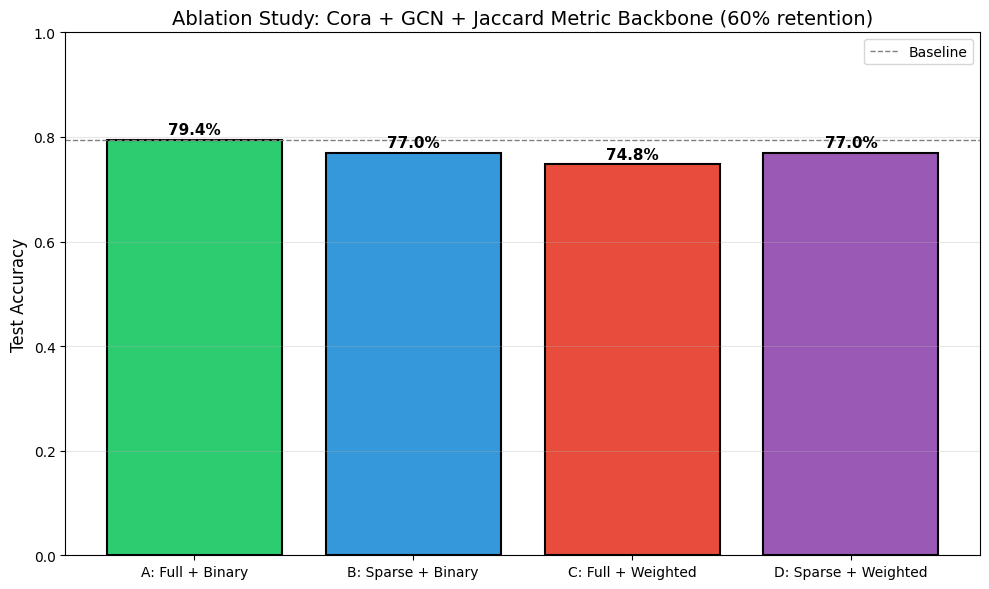

In [7]:
scenarios = results_df["Scenario"].tolist()
accuracies = results_df["Accuracy"].tolist()
colors = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(scenarios, accuracies, color=colors, edgecolor="black", linewidth=1.5)

ax.axhline(baseline, color="gray", linestyle="--", linewidth=1, label="Baseline")

for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
            f"{acc:.1%}", ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title("Ablation Study: Cora + GCN + Jaccard Metric Backbone (60% retention)", fontsize=14)
# Note: This initial study uses Jaccard. Section 3 compares all three metrics.
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Multi-Configuration Study

Run ablation studies across multiple retention ratios and metrics (Jaccard, Effective Resistance, Adamic Adar).

In [8]:
all_results_df = study.run_multi_config_study(
    model_names=["gcn"],
    metrics=["jaccard", "effective_resistance", "adamic_adar"],
    retention_ratios=[1 - i/10 for i in range(10)],
    hidden_channels=64,
    epochs=200,
    patience=20,
    use_metric_backbone=True,
 )


Config: gcn | jaccard | 100% | Seed: 42

Config: gcn | jaccard | 90% | Seed: 42

Config: gcn | jaccard | 80% | Seed: 42

Config: gcn | jaccard | 70% | Seed: 42

Config: gcn | jaccard | 60% | Seed: 42

Config: gcn | jaccard | 50% | Seed: 42

Config: gcn | jaccard | 40% | Seed: 42

Config: gcn | jaccard | 30% | Seed: 42

Config: gcn | jaccard | 20% | Seed: 42

Config: gcn | jaccard | 10% | Seed: 42

Config: gcn | effective_resistance | 100% | Seed: 42

Config: gcn | effective_resistance | 90% | Seed: 42


LinAlgError: SVD did not converge

In [ ]:
all_results_df

### 3.1 Retention Ratio Impact by Metric

In [ ]:
metrics_list = all_results_df["Metric"].unique()
fig, axes = plt.subplots(1, len(metrics_list), figsize=(18, 6))

if len(metrics_list) == 1:
    axes = [axes]

scenario_names = ["A: Full + Binary", "B: Sparse + Binary", "C: Full + Weighted", "D: Sparse + Weighted"]
colors = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

for metric_idx, metric in enumerate(metrics_list):
    ax = axes[metric_idx]
    metric_data = all_results_df[all_results_df["Metric"] == metric]
    retention_ratios = sorted(metric_data["Retention"].unique())
    
    x = np.arange(len(retention_ratios))
    width = 0.2
    
    for i, scenario in enumerate(scenario_names):
        accs = []
        for retention in retention_ratios:
            acc_vals = metric_data[(metric_data["Retention"] == retention) & 
                                   (metric_data["Scenario"] == scenario)]["Accuracy"].values
            if len(acc_vals) > 0:
                accs.append(acc_vals[0])
            else:
                accs.append(0)
        ax.bar(x + i * width, accs, width, label=scenario, color=colors[i], edgecolor="black")
    
    ax.set_xlabel("Retention Ratio", fontsize=11)
    ax.set_ylabel("Test Accuracy", fontsize=11)
    ax.set_title(f"{metric.replace('_', ' ').title()}", fontsize=12)
    ax.set_xticks(x + 1.5 * width)
    ax.set_xticklabels([f"{r:.0%}" for r in retention_ratios], rotation=45)
    if metric_idx == len(metrics_list) - 1:
        ax.legend(loc="upper right", fontsize=9)
    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim(0.6, 0.9)

fig.suptitle("Ablation Study: Impact of Retention Ratio Across Metrics", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Cross-Model Comparison

Compare ablation results across different GNN architectures with all three metrics.

In [ ]:
cross_model_df = study.run_multi_config_study(
    model_names=["gcn", "sage", "gat"],
    metrics=["jaccard", "effective_resistance", "adamic_adar"],
    retention_ratios=[0.6],
    hidden_channels=64,
    epochs=200,
    patience=20,
    use_metric_backbone=True,
)

### 4.1 Comparative Analysis of Architectures

**(Retrospective)** We have successfully executed the multi-configuration ablation study across GCN, GraphSAGE, and GAT models.

**(Prospective)** To facilitate a direct comparison, we will now pivot this data into a side-by-side table. This format will allow us to see if models with learnable attention (GAT) react differently to explicit weighting compared to fixed-topology models (GCN).

In [ ]:
for metric in cross_model_df["Metric"].unique():
    print("\n" + "=" * 90)
    print(f"CROSS-MODEL COMPARISON (60% Retention, {metric.replace('_', ' ').title()})")
    print("=" * 90)
    metric_data = cross_model_df[cross_model_df["Metric"] == metric]
    pivot_df = metric_data.pivot(index="Model", columns="Scenario", values="Accuracy")
    print(pivot_df.to_string())
    print()

In [ ]:
metrics_list = cross_model_df["Metric"].unique()
models = ["gcn", "sage", "gat"]
colors = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

fig, axes = plt.subplots(len(metrics_list), 3, figsize=(15, 5 * len(metrics_list)))

if len(metrics_list) == 1:
    axes = axes.reshape(1, -1)

for metric_idx, metric in enumerate(metrics_list):
    metric_data = cross_model_df[cross_model_df["Metric"] == metric]
    
    for model_idx, model_name in enumerate(models):
        ax = axes[metric_idx, model_idx]
        model_metric_data = metric_data[metric_data["Model"] == model_name]
        
        # Get accuracies in the correct order
        scenario_order = ["A: Full + Binary", "B: Sparse + Binary", "C: Full + Weighted", "D: Sparse + Weighted"]
        accs = []
        for scenario in scenario_order:
            acc_val = model_metric_data[model_metric_data["Scenario"] == scenario]["Accuracy"].values
            accs.append(acc_val[0] if len(acc_val) > 0 else 0)
        
        ax.bar(range(4), accs, color=colors, edgecolor="black")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["A", "B", "C", "D"])
        ax.set_ylabel("Test Accuracy")
        ax.set_title(f"{model_name.upper()} - {metric.replace('_', ' ').title()}")
        ax.set_ylim(0.6, 0.9)
        ax.grid(axis="y", alpha=0.3)
        
        if len(accs) > 0 and accs[0] > 0:
            ax.axhline(accs[0], color="gray", linestyle="--", alpha=0.5, label="Baseline")

fig.suptitle("Ablation Study Across GNN Architectures and Metrics (Cora Metric Backbone, 60% Retention)", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Summary

In this notebook, we ran controlled ablation studies using the metric backbone to understand:

1. **Structure vs Weighting**: Comparing scenarios B and C to the baseline A
   - B isolates the effect of metric backbone sparsification (removing redundant edges via RTI)
   - C isolates the effect of edge re-weighting (emphasizing important edges)
2. **Interaction Effects**: Whether combining sparsification and weighting (D) provides additional benefit
   - Positive interaction: synergistic (combined > sum of parts)
   - Zero interaction: purely additive (combined = sum of parts)
   - Negative interaction: interference (combined < sum of parts)
3. **Model Sensitivity**: How different GNN architectures respond to metric backbone sparsification

**Key Takeaways:**
- The 4-scenario framework isolates structural and weighting effects independently
- Metric backbone uses Relaxed Triangle Inequality (RTI) to remove redundant edges
- Different models may benefit differently from each intervention
- The interaction term reveals whether effects are additive or synergistic